In [3]:
%matplotlib inline

from joblib import dump, load
import itertools
import json
import math
import os
import random
import time
from typing import Callable, Dict, List

from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from hyperopt.pyll.base import scope
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# scikit-learn
import sklearn
from sklearn.base import clone
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix, \
    f1_score, fbeta_score, log_loss, make_scorer, precision_recall_fscore_support, \
    precision_score, precision_recall_curve, recall_score
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC

# Models
from xgboost import XGBClassifier

# Tensorflow
# import tensorflow as tf
# import tensorflow_hub as hub
# from tensorflow import keras
# from tensorflow.keras.optimizers import SGD, Adam
# from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback


# NLP
import gc
import re
import string
import operator
from collections import defaultdict


# Configure options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

random_state = 11

random.seed(random_state)
np.random.seed(random_state)

In [4]:
root = '/home/jovyan/work/Documents/kaggle_competitions/house-prices-advanced-regression-techniques'
os.listdir(root)

['test.csv',
 'data_description.txt',
 'train.csv',
 '.ipynb_checkpoints',
 'sample_submission.csv']

In [5]:
pd.read_csv(root + '/sample_submission.csv')

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


In [630]:
df = pd.read_csv(root + '/train.csv')

def get_types(df):
    dtypes = defaultdict(list)
    for col, dtype in df.dtypes.items():
        dtypes[str(dtype)].append(col)
    return dtypes

col_dtypes = get_types(df)
col_dtypes['numeric'] = col_dtypes['int64'] + col_dtypes['float64']
col_dtypes.keys()

df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,Gas

In [7]:
# No duplicates
df[df['Id'].duplicated()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [8]:
df[~df['PoolQC'].isnull()]['PoolQC'][:5]

197     Ex
810     Fa
1170    Gd
1182    Ex
1298    Gd
Name: PoolQC, dtype: object

In [9]:
df[~df['MiscFeature'].isnull()]['MiscFeature'][:5]

5     Shed
7     Shed
16    Shed
17    Shed
51    Shed
Name: MiscFeature, dtype: object

In [10]:
df[~df['Alley'].isnull()]['Alley'][:5]

21    Grvl
30    Pave
56    Pave
79    Grvl
87    Pave
Name: Alley, dtype: object

In [11]:
df[~df['Fence'].isnull()]['Fence'][:5]

5     MnPrv
14     GdWo
15    GdPrv
19    MnPrv
21    GdPrv
Name: Fence, dtype: object

# Target variable exploration

In [12]:
target = 'SalePrice'
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

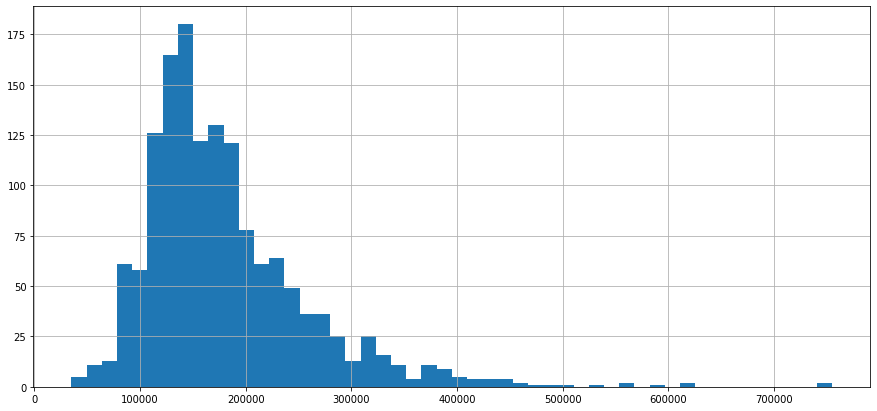

In [13]:
df['SalePrice'].hist(bins=50, figsize=(15, 7))

Skewness: 1.882876
Kurtosis: 6.536282


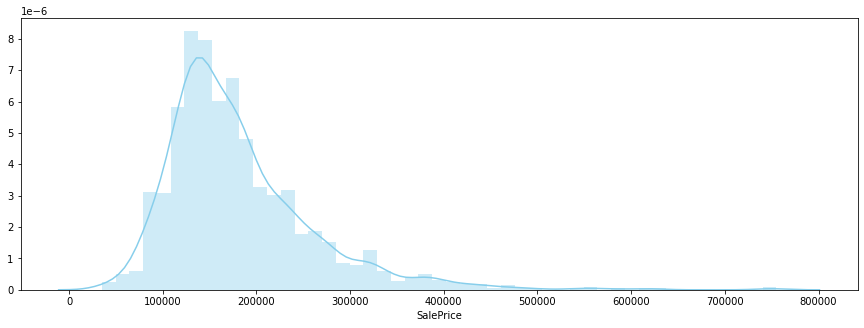

In [235]:
f, ax = plt.subplots(figsize=(15, 5))
sns.distplot(df['SalePrice'], color='skyblue', ax=ax)
print("Skewness: %f" % df['SalePrice'].skew())
print("Kurtosis: %f" % df['SalePrice'].kurt())


 mu = 180921.20 and sigma = 79415.29



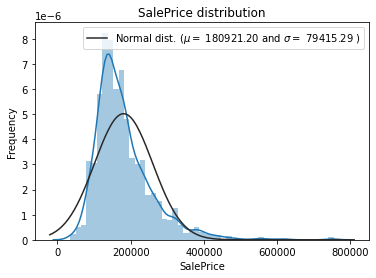

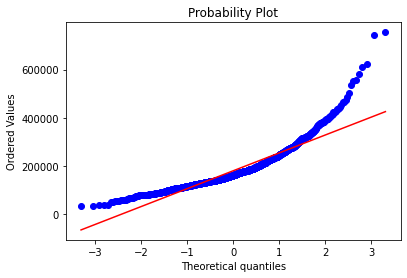

In [740]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm  # for some statistic

def plot_normal_distribution(data):
    sns.distplot(data , fit=norm)

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)
    print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    # Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('SalePrice distribution')

    # Get the QQ-plot
    fig = plt.figure()
    res = stats.probplot(data, plot=plt)
    plt.show()
    
plot_normal_distribution(df[target])

In [15]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
  

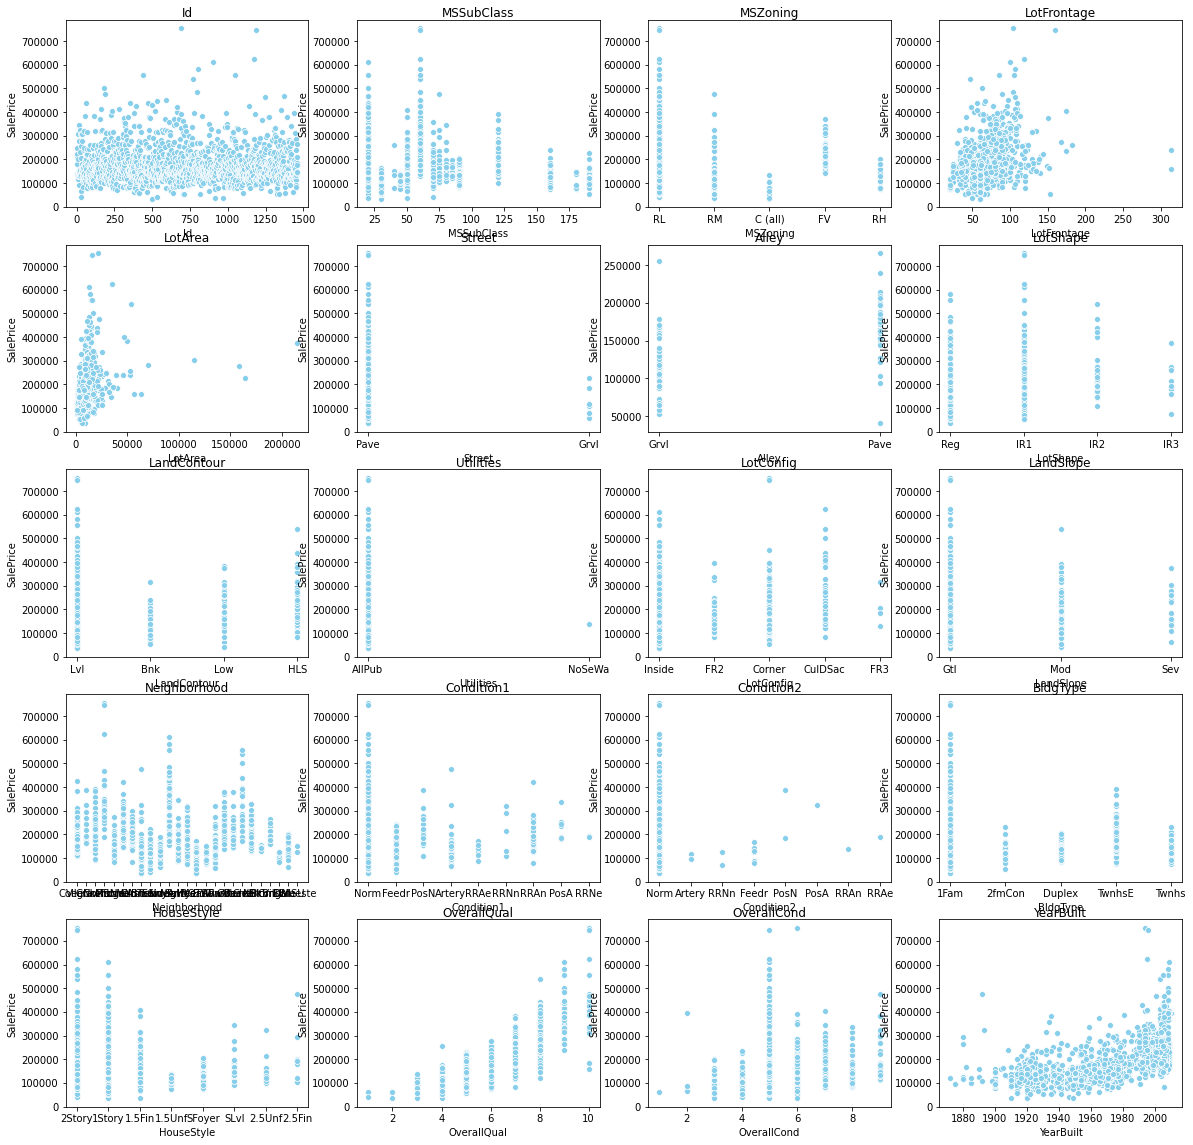

In [16]:
def plot_scatter_against_target(df, columns, target):
    if len(columns) < 5:
        n_cols = 2
    else:
        n_cols = 4

    n_rows = math.ceil(len(columns) / n_cols)
    f, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
    for ax, feature in zip(axes.flat, columns):
        sns.scatterplot(df[feature], df[target], color="skyblue", ax=ax)
        ax.set_title(feature, pad=-10)


def plot_multiple_plots(max_features_per_plot, df, columns, plot_func, **plot_func_args):
    num_plots = math.ceil(len(columns) / max_features_per_plot)
    features_per_plot = math.ceil(len(columns) / num_plots)
    for plot_num in range(num_plots):
        start = features_per_plot * plot_num
        end = start + features_per_plot
        plot_func(df, columns[start:end], **plot_func_args)
        

# LotFrontage, OverallQual, YearBuilt, YearRemodAdd, BsmtFinSF1, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, 
# GrLivArea, GrYearBuilt, GarageCars
plot_scatter_against_target(df, df.columns[:20], target)

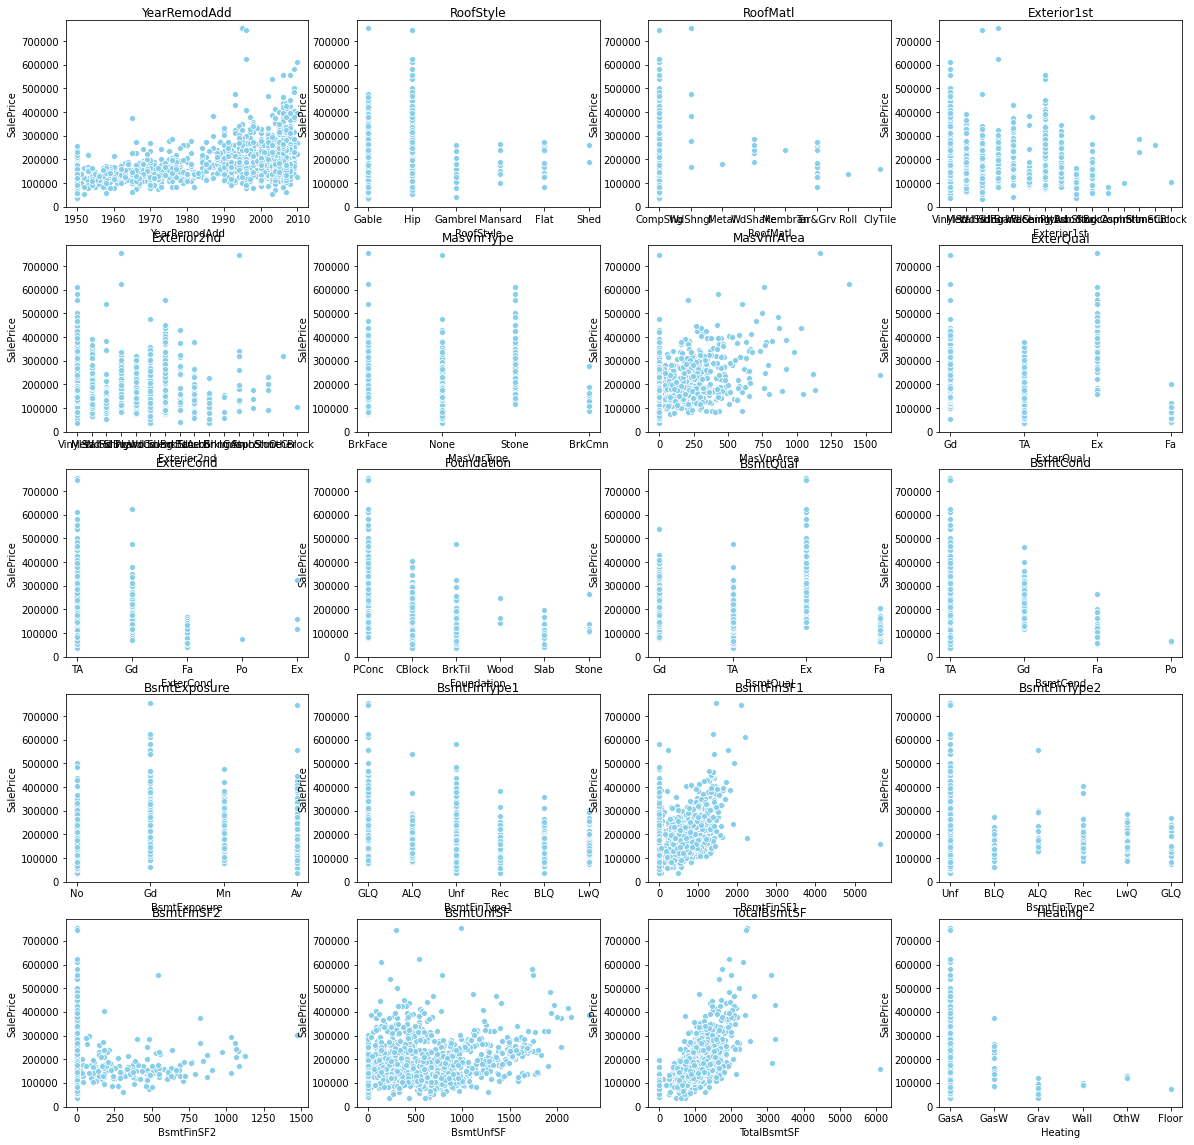

In [17]:
plot_scatter_against_target(df, df.columns[20:40], target)

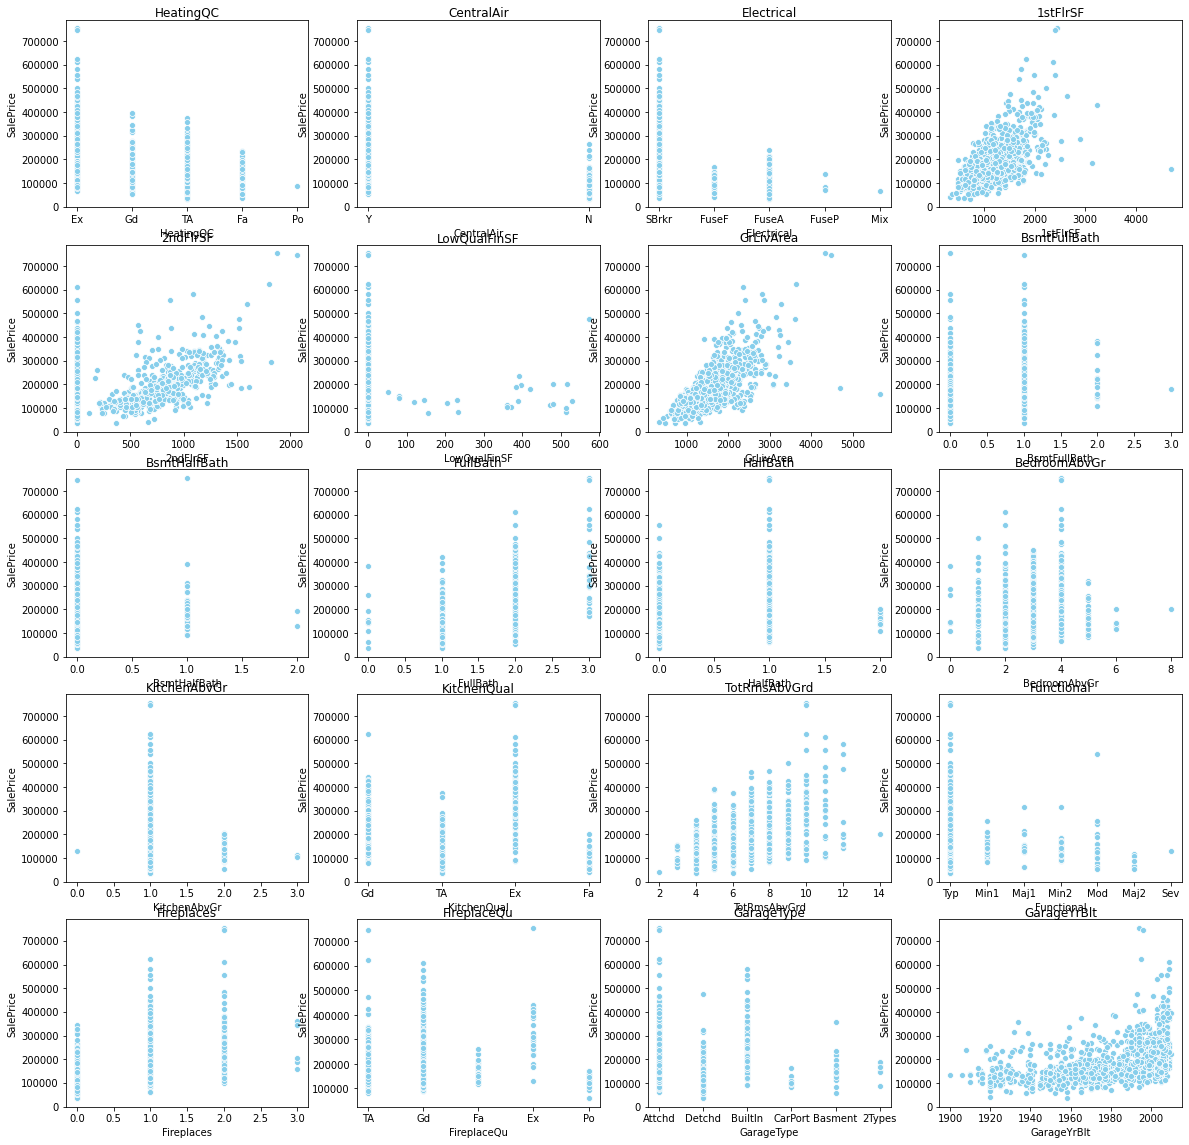

In [18]:
plot_scatter_against_target(df, df.columns[40:60], target)

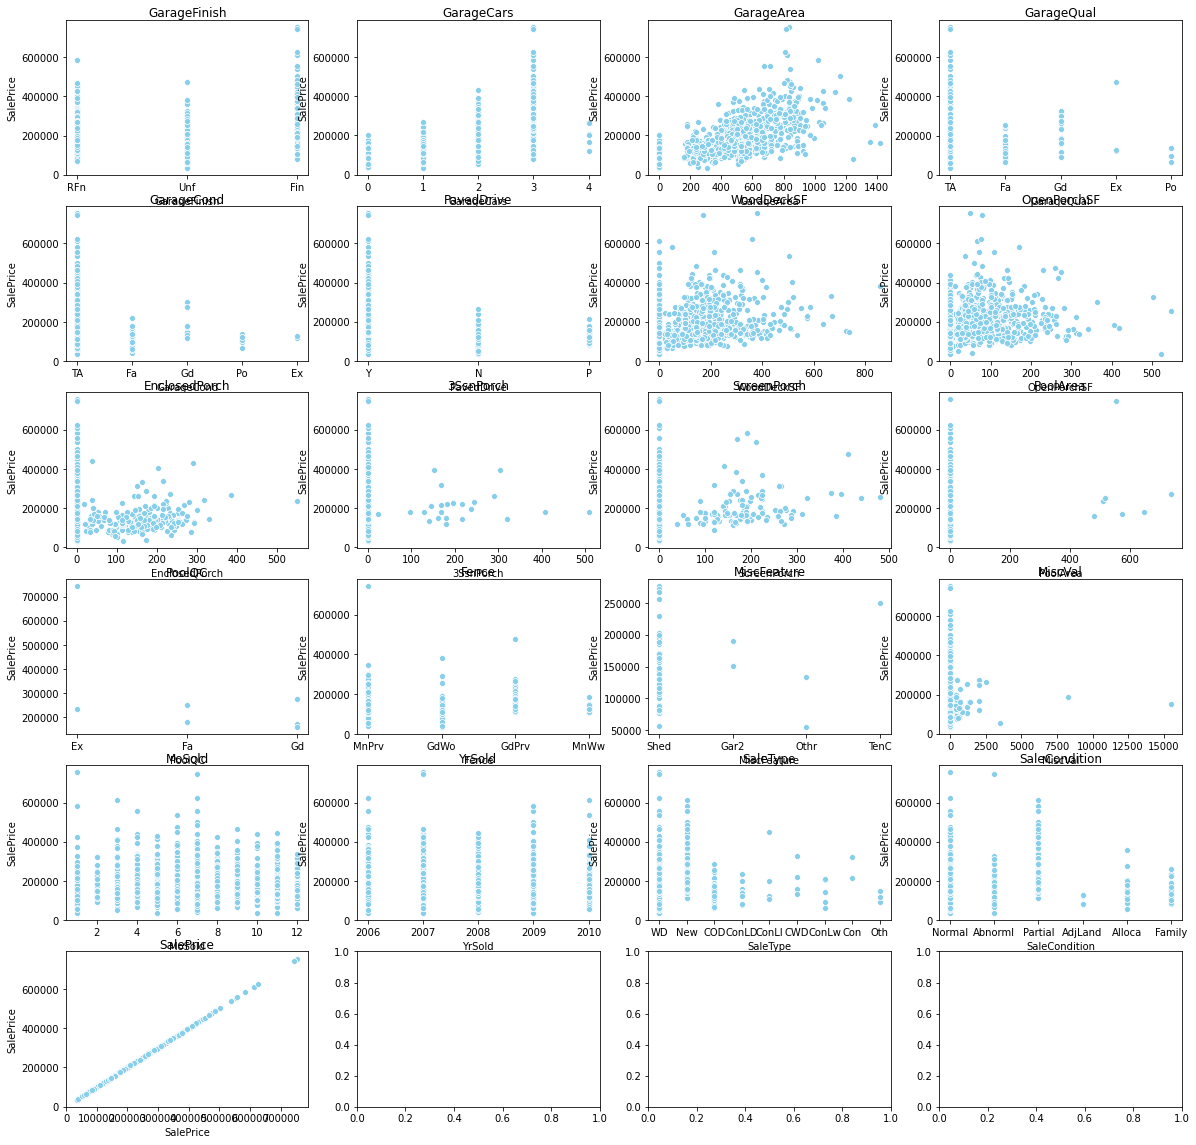

In [19]:
plot_scatter_against_target(df, df.columns[60:], target)

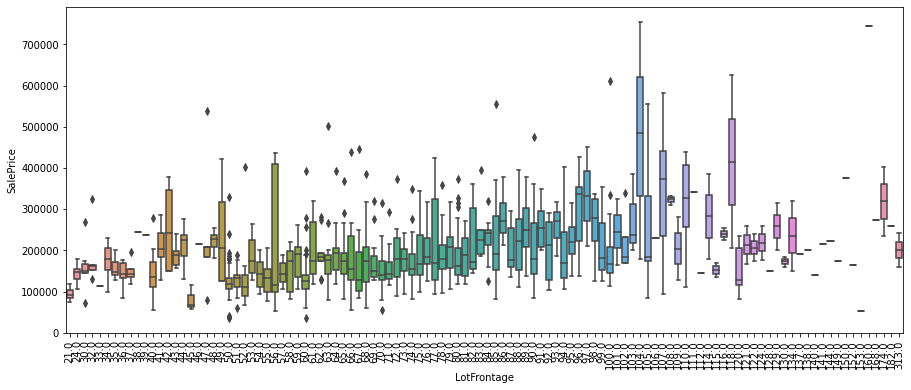

In [20]:
# LotFrontage, OverallQual, YearBuilt, YearRemodAdd, BsmtFinSF1, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, 
# GrLivArea, GrYearBuilt, GarageCars
def plot_boxplot_against_target(df, feature, target):
    f, ax = plt.subplots(figsize=(15, 6))
    sns.boxplot(x=feature, y=target, data=df[[feature, target]], ax=ax)
    plt.xticks(rotation=90)
    
plot_boxplot_against_target(df, 'LotFrontage', target)

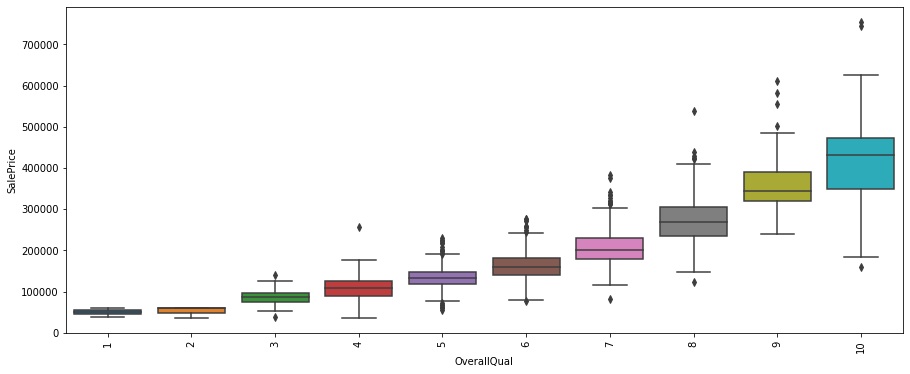

In [21]:
plot_boxplot_against_target(df, 'OverallQual', target)

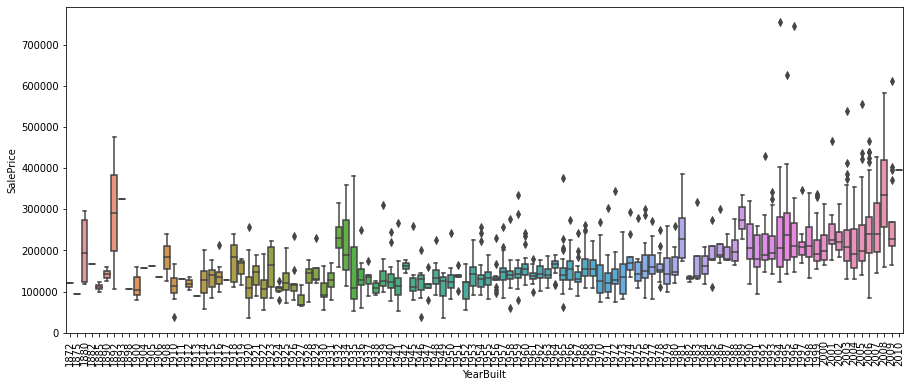

In [22]:
plot_boxplot_against_target(df, 'YearBuilt', target)

In [540]:
def correlation_heatmap(df, target=None, n_largest=None):
    f, ax = plt.subplots(figsize=(12, 9))
    corrmat = df.corr(method='kendall')
    if n_largest is not None:
        cols = corrmat.nlargest(n_largest, target)[target].index
        cm = np.corrcoef(df[cols].values.T)
        sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values,
                    xticklabels=cols.values)
    else:
        cols = []
        sns.heatmap(corrmat, vmax=.8, square=True)
        
    return cols
        

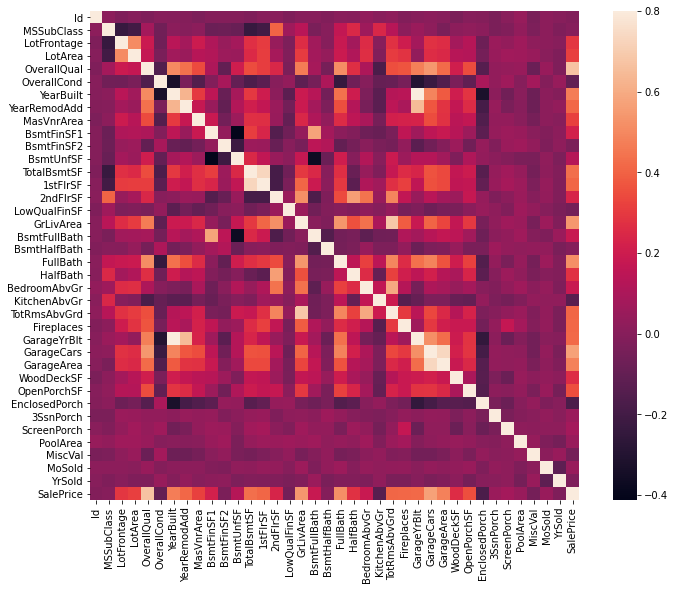

In [541]:
important_cols = correlation_heatmap(df, target)

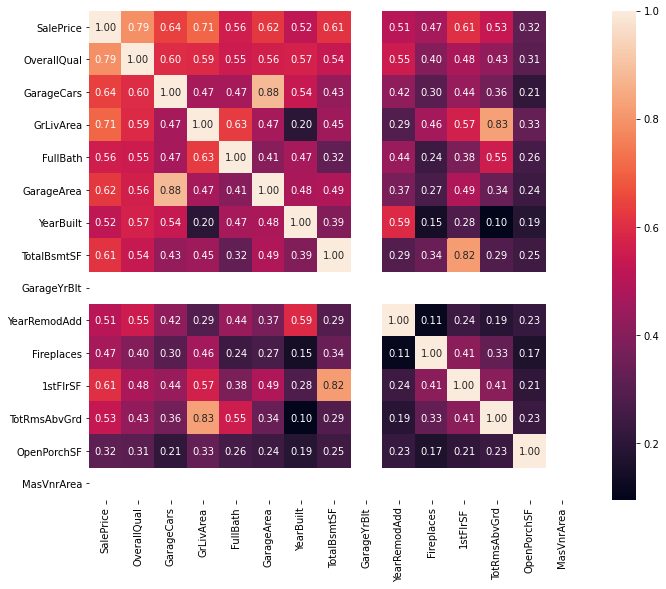

In [544]:
important_cols = correlation_heatmap(df, target, 15)

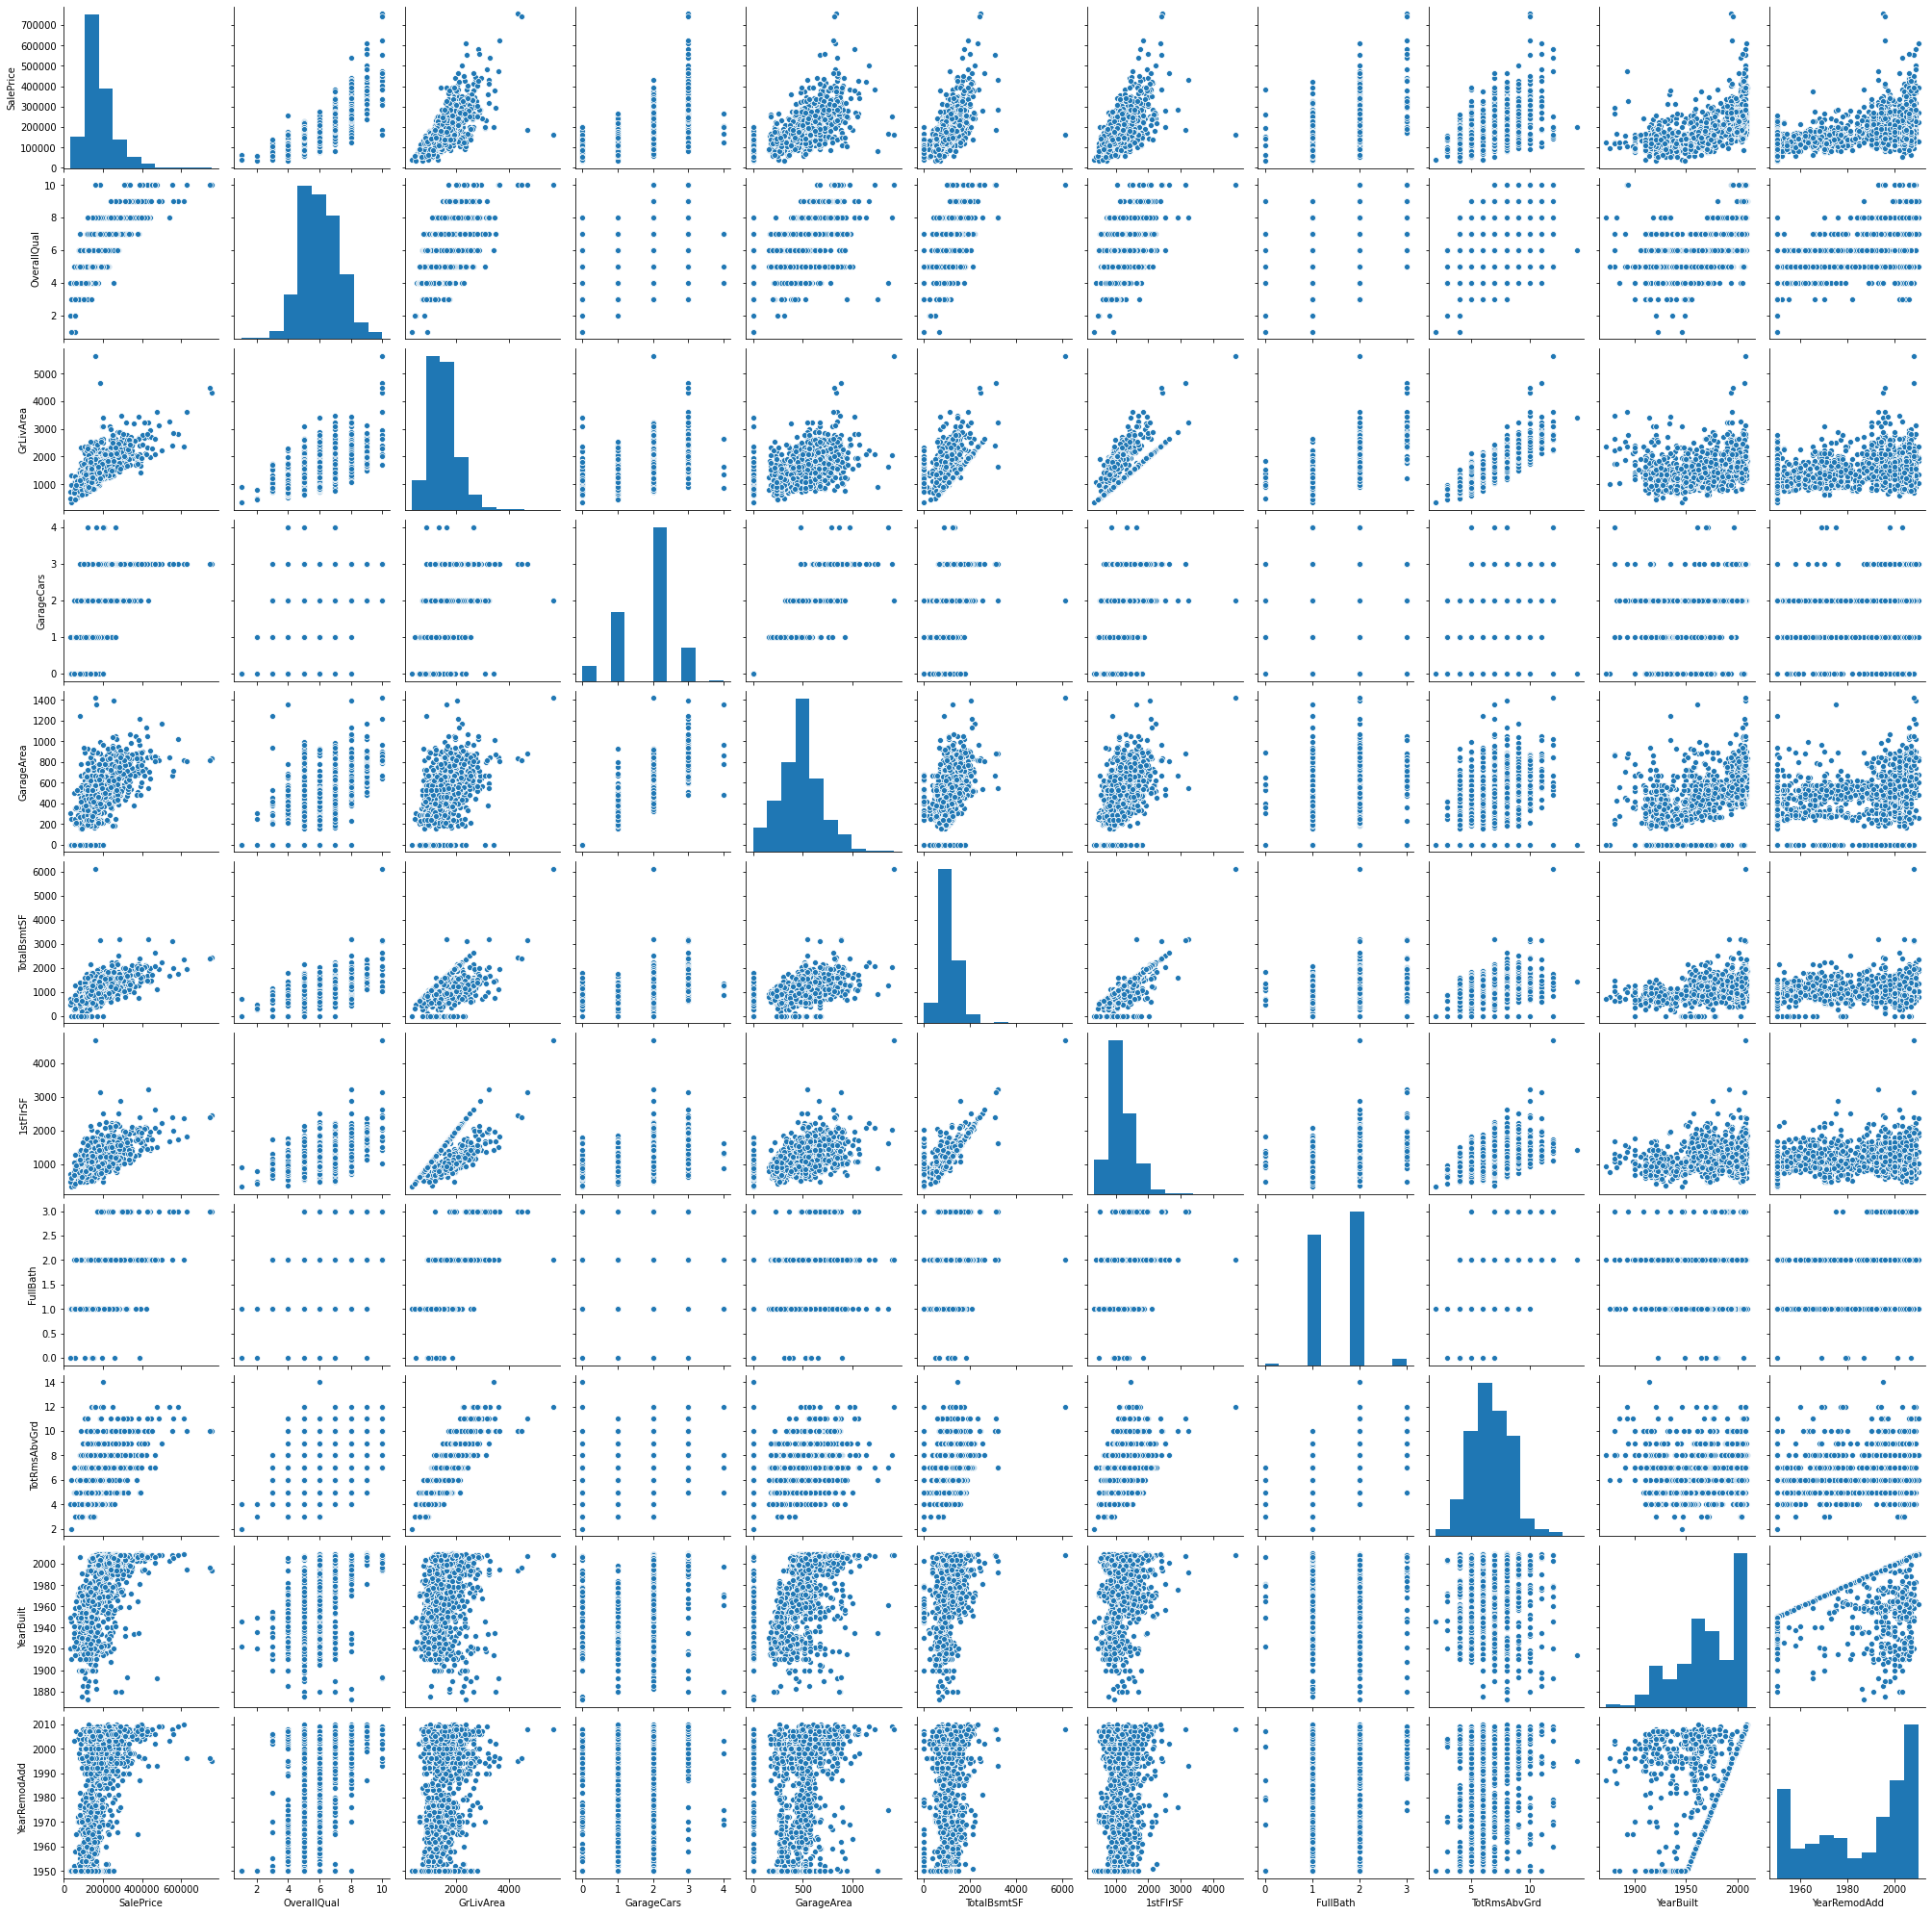

In [26]:
sns.pairplot(df[important_cols])

In [27]:
def get_missing_stats(df, columns):
    dtypes = df.dtypes
    missing_cols = []
    for column in columns:
        missing = df[df[column].isnull()]

        if len(missing) > 0:
            missing_cols.append({'column': column,
                                 'dtype': str(dtypes[column]),
                                 'num_missing': len(missing),
                                 'num_not_missing': len(df) - len(missing),
                                 'pct_missing': len(missing) / len(df)})

    return pd.DataFrame(missing_cols).sort_values(by='pct_missing', ascending=False)


missing_stats = get_missing_stats(df, df.columns)
missing_stats

,column,dtype,num_missing,num_not_missing,pct_missing
16,PoolQC,object,1453,7,0.995205
18,MiscFeature,object,1406,54,0.963014
1,Alley,object,1369,91,0.937671
17,Fence,object,1179,281,0.807534
10,FireplaceQu,object,690,770,0.472603
0,LotFrontage,float64,259,1201,0.177397
11,GarageType,object,81,1379,0.055479
12,GarageYrBlt,float64,81,1379,0.055479
13,GarageFinish,object,81,1379,0.055479
14,GarageQual,object,81,1379,0.055479


In [29]:
def print_relative_frequencies(df, columns):
    for column in columns:
        print('\n')
        print(column)
        print(df[column].value_counts() / len(df) * 100)


# Lots of ordinal and categorical variables with a lot of levels
print_relative_frequencies(df, col_dtypes['object'])
    



MSZoning
RL         78.835616
RM         14.931507
FV          4.452055
RH          1.095890
C (all)     0.684932
Name: MSZoning, dtype: float64


Street
Pave    99.589041
Grvl     0.410959
Name: Street, dtype: float64


Alley
Grvl    3.424658
Pave    2.808219
Name: Alley, dtype: float64


LotShape
Reg    63.356164
IR1    33.150685
IR2     2.808219
IR3     0.684932
Name: LotShape, dtype: float64


LandContour
Lvl    89.794521
Bnk     4.315068
HLS     3.424658
Low     2.465753
Name: LandContour, dtype: float64


Utilities
AllPub    99.931507
NoSeWa     0.068493
Name: Utilities, dtype: float64


LotConfig
Inside     72.054795
Corner     18.013699
CulDSac     6.438356
FR2         3.219178
FR3         0.273973
Name: LotConfig, dtype: float64


LandSlope
Gtl    94.657534
Mod     4.452055
Sev     0.890411
Name: LandSlope, dtype: float64


Neighborhood
NAmes      15.410959
CollgCr    10.273973
OldTown     7.739726
Edwards     6.849315
Somerst     5.890411
Gilbert     5.410959
NridgHt     5.

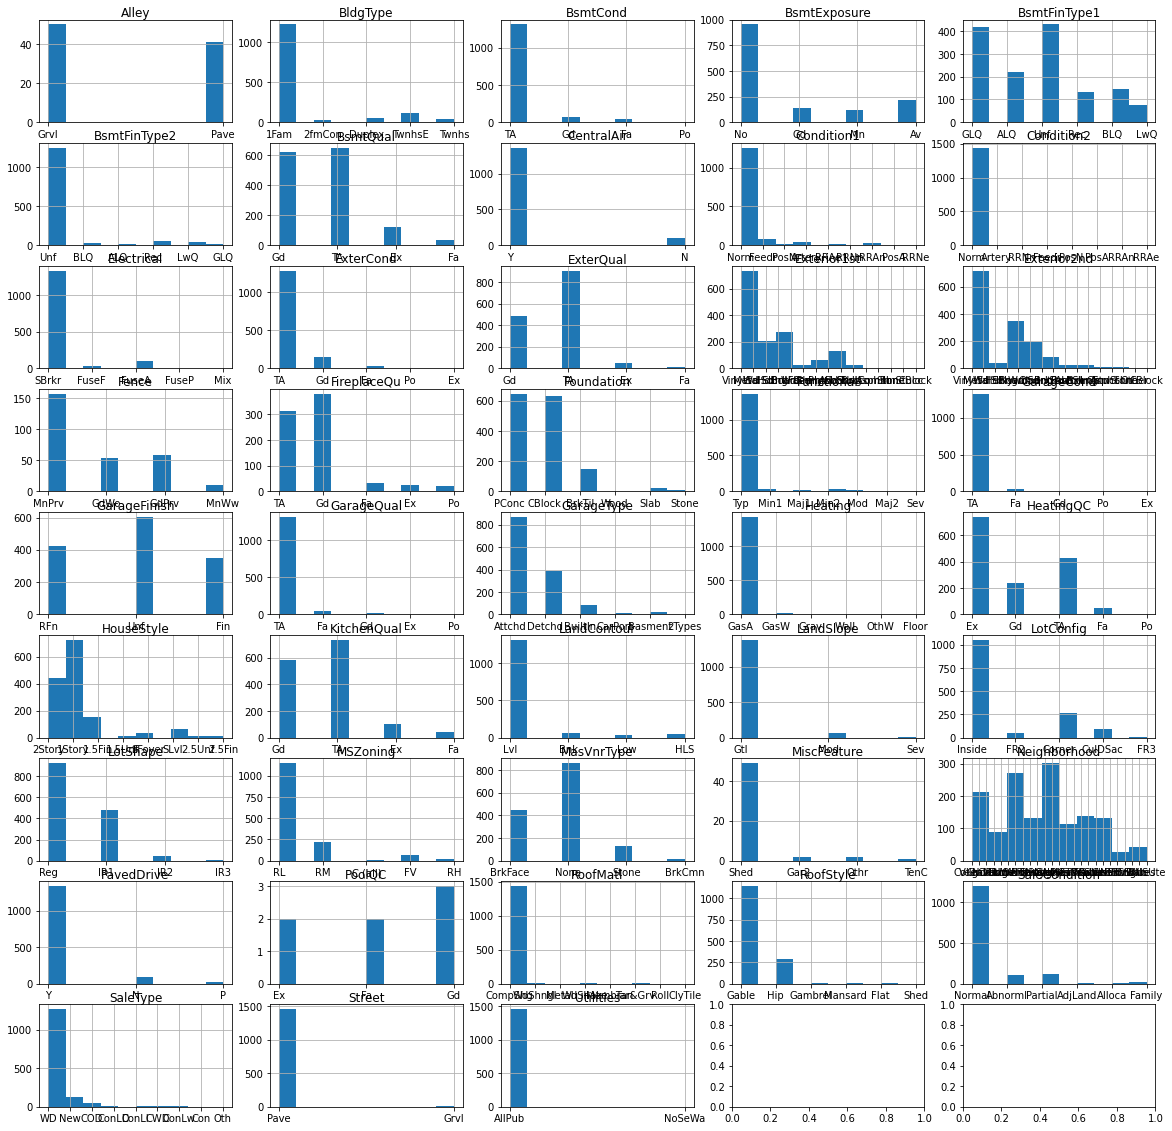

In [30]:
def histogram_grid(df, columns):
    """
    :param df:
    :param columns: Must be numeric type
    :return:
    """
    if len(columns) < 4:
        n_cols = 2
    else:
        n_cols = 5
    n_rows = math.ceil(len(columns) / n_cols)
    f, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
    for ax, feature in zip(axes.flat, sorted(columns)):
        df[feature].hist(ax=ax)
        ax.set_title(feature, pad=-10)
        
histogram_grid(df, col_dtypes['object'])

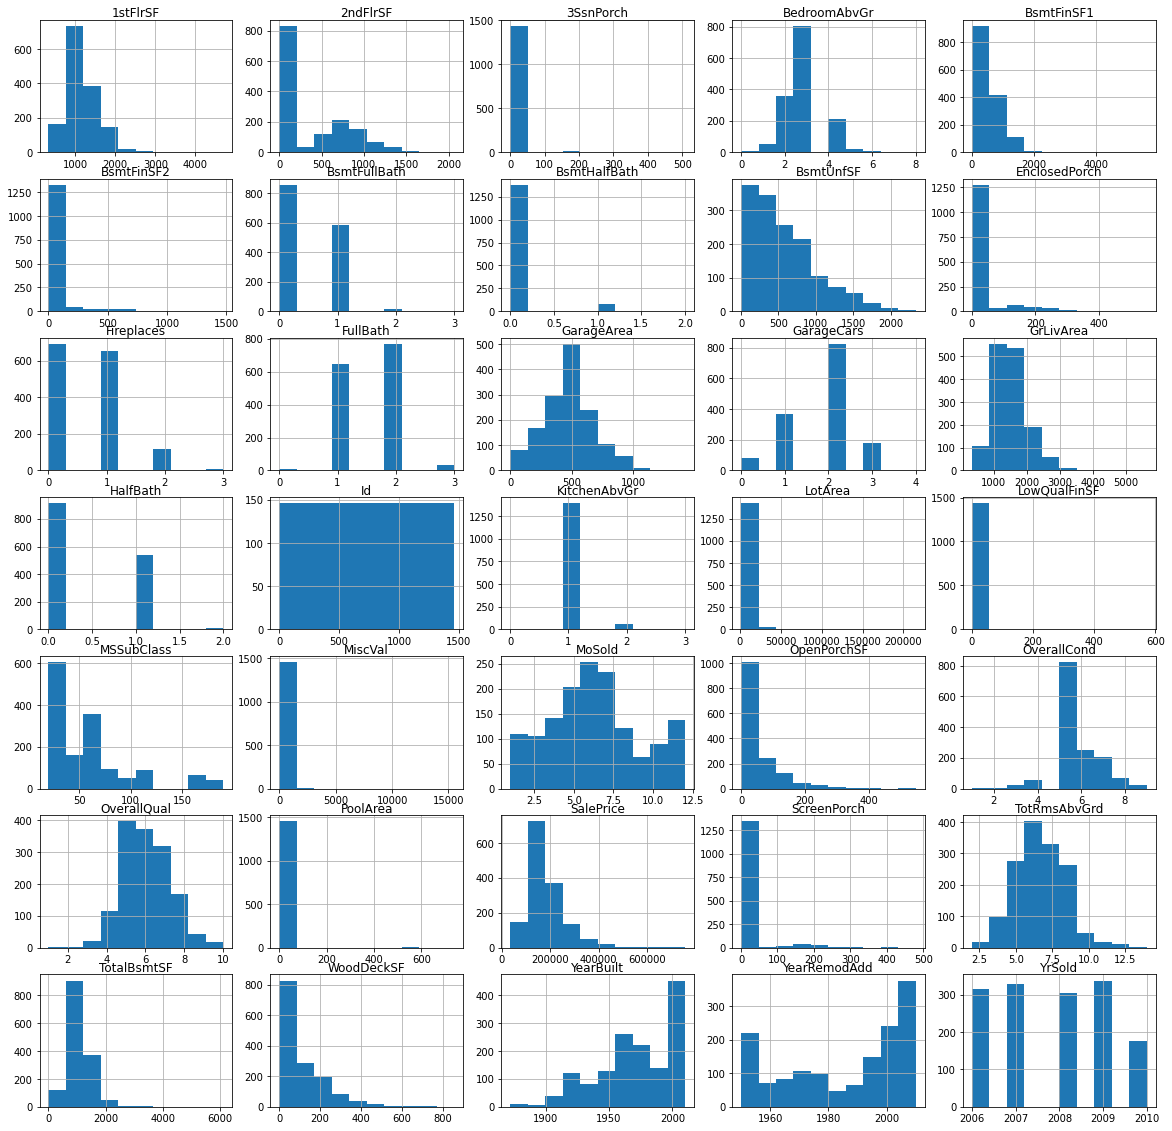

In [31]:
histogram_grid(df, col_dtypes['int64'])

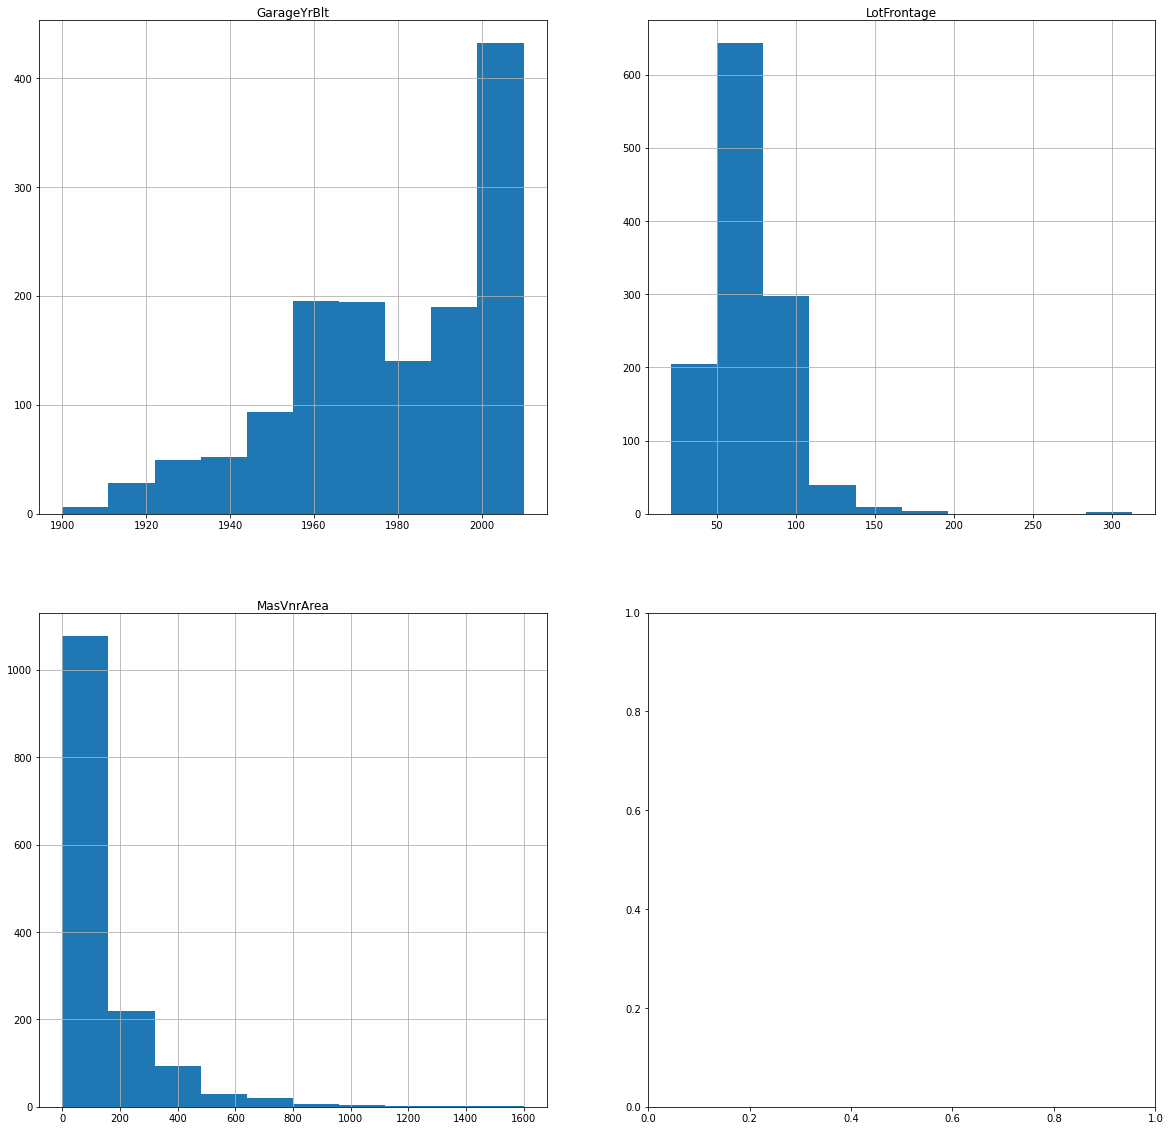

In [32]:
histogram_grid(df, col_dtypes['float64'])

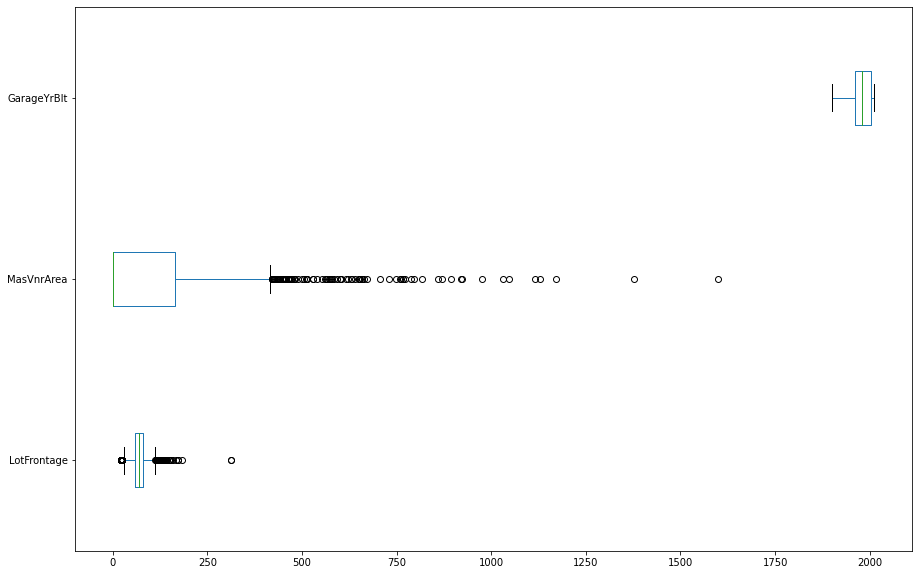

In [33]:
df[col_dtypes['float64']].plot.box(vert=False, figsize=(15, 10))

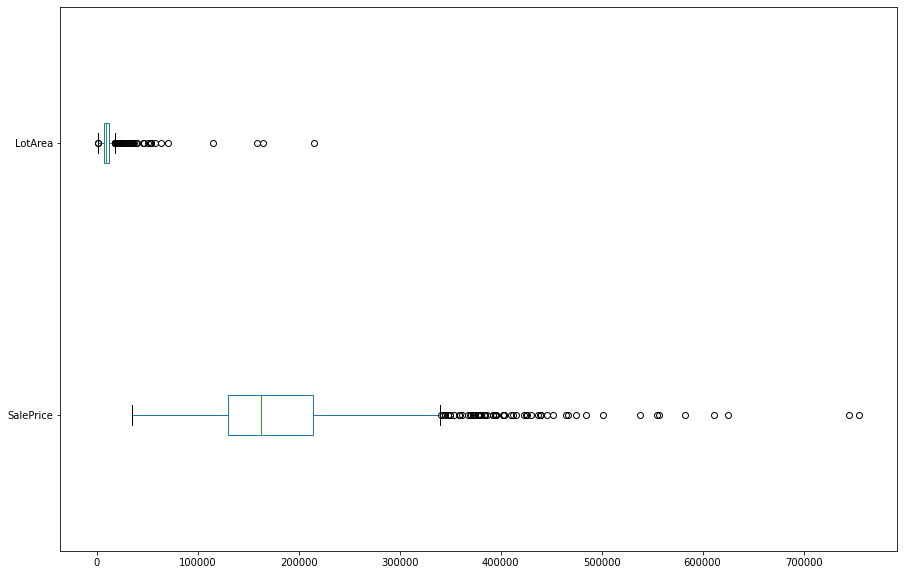

In [34]:
df[['SalePrice', 'LotArea']].plot.box(vert=False, figsize=(15, 10))

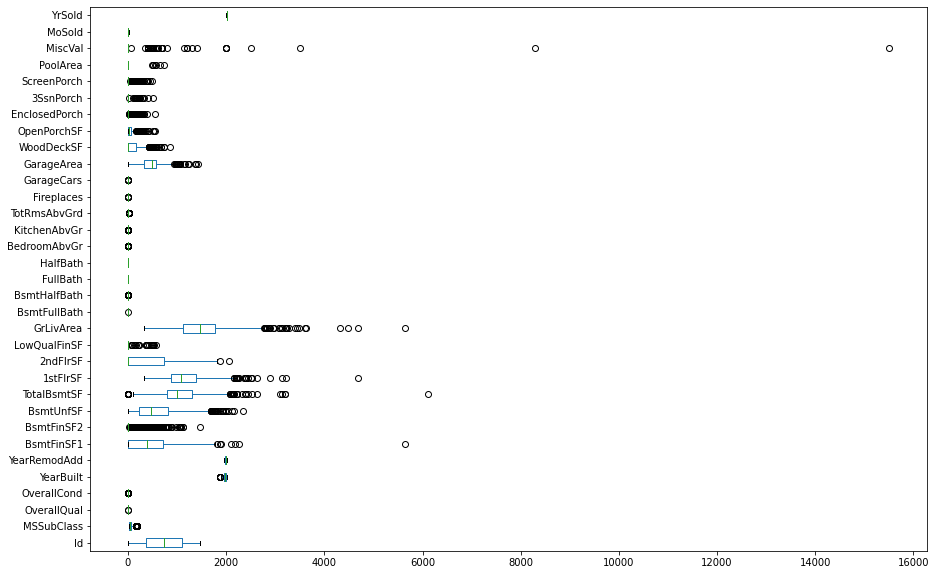

In [35]:
df[col_dtypes['int64']].drop(['SalePrice', 'LotArea'], axis=1).plot.box(vert=False, figsize=(15, 10))

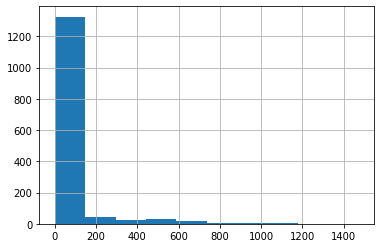

In [36]:
df['BsmtFinSF2'].hist()

In [ ]:
def distplot_grid(df, columns):
    """
    :param df:
    :param columns: Must be numeric type
    :return:
    """
    if len(columns) < 5:
        n_cols = 2
    else:
        n_cols = 4
    
    n_rows = math.ceil(len(columns) / n_cols)
    f, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
    for ax, feature in zip(axes.flat, columns):
        try:
            sns.distplot(df[feature], hist=False, color="skyblue", ax=ax)
        except Exception as ex:
            print('Could not set KDE for feature', feature)
            df[feature].hist(ax=ax)
        ax.set_title(feature, pad=-10)

distplot_grid(df, col_dtypes['int64'])

In [ ]:
# def facet(df, x_column, y_column, hue_column, by_column):
#     g = sns.FacetGrid(tips, col="time", row="smoker")
#     g = g.map(plt.hist, by_column)
#     plt.show()



# Data cleaning

In [276]:
missing_stats

,column,dtype,num_missing,num_not_missing,pct_missing
16,PoolQC,object,1453,7,0.995205
18,MiscFeature,object,1406,54,0.963014
1,Alley,object,1369,91,0.937671
17,Fence,object,1179,281,0.807534
10,FireplaceQu,object,690,770,0.472603
0,LotFrontage,float64,259,1201,0.177397
11,GarageType,object,81,1379,0.055479
12,GarageYrBlt,float64,81,1379,0.055479
13,GarageFinish,object,81,1379,0.055479
14,GarageQual,object,81,1379,0.055479


In [388]:
from sklearn.model_selection import StratifiedKFold

import numpy as np


class BinnedStratifiedKFold(StratifiedKFold):
    """
    StratifiedKFold doesn't support continuous variables yet:
    https://github.com/scikit-learn/scikit-learn/issues/4757

    PR is in progress:
    https://github.com/scikit-learn/scikit-learn/pull/14560/files
    """

    def __init__(self, n_splits=5, shuffle=False, n_bins=5,
                 random_state=None):
        super().__init__(n_splits, shuffle, random_state)
        self.n_bins = n_bins
        if n_bins < 2:
            raise ValueError("Need at least two bins, got {}.".format(
                n_bins))

    @staticmethod
    def get_bins(y, n_bins):
        percentiles = np.percentile(y, np.linspace(0, 100, n_bins))
        return np.searchsorted(percentiles[1:-1], y)

    def _make_test_folds(self, X, y):
        bins = self.get_bins(y, self.n_bins + 1)
        return super()._make_test_folds(X, bins)

    def _iter_test_indices(self, X=None, y=None, groups=None):
        pass

In [965]:
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import KNNImputer

col_dtypes = get_types(df)
x = df[col_dtypes['object'] + col_dtypes['int64'] + col_dtypes['float64']].drop(target, axis=1)

def astype_str(x):
    return x.astype(str)

int_to_str_columns = ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold', 'YearRemodAdd', 'GarageYrBlt']

for col in int_to_str_columns:
    x[col] = x[col].astype(str)
# TODO - find a way to use a ColumnTransformer for int to str conversion
# astype_str_transformer = ColumnTransformer([
#     ('astype_str', FunctionTransformer(astype_str), int_to_str_columns)
# ], remainder='passthrough')


y = np.log(df[[target]])

bins = BinnedStratifiedKFold.get_bins(y, 5)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, stratify=bins,
                                                        random_state=random_state)

def validate_splits(xtrain, xtest, ytrain, ytest):
    print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)
    assert xtrain.shape[1] == xtest.shape[1] 
    assert len(ytrain.shape) == len(ytest.shape)
    
    assert xtrain.shape[0] == ytrain.shape[0] 
    assert xtest.shape[0] == ytest.shape[0] 

validate_splits(xtrain, xtest, ytrain, ytest)


(1095, 80) (365, 80) (1095, 1) (365, 1)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f85ec81a198>]],
      dtype=object)

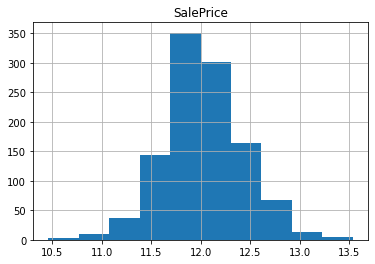

In [633]:
pd.DataFrame(ytrain).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f85e9841780>]],
      dtype=object)

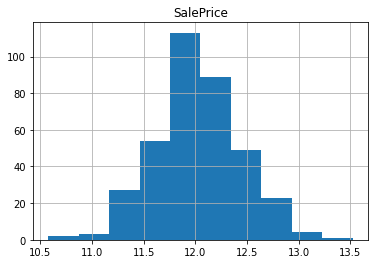

In [634]:
pd.DataFrame(ytest).hist()

In [977]:
col_dtypes = get_types(x)

# Drop any feature with < 100 observations: PoolQC, MiscFeature, Alley. 
# Also drop Fence for now because it's not an easily interpretable feature and has lots of missing vars.
# Drop Id because it has nothing to do with the houses
# Drop target because it's the dependent variable
columns_to_drop = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'Id', target]

ordinal_columns = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold']
ordinal_columns = list(filter(lambda col: col not in columns_to_drop, ordinal_columns))
categorical_columns = list(filter(lambda col: col not in columns_to_drop and col not in ordinal_columns, 
                                  col_dtypes['object']))
numerical_columns = list(filter(lambda col: col not in columns_to_drop and col not in int_to_str_columns, 
                                col_dtypes['int64'] + col_dtypes['float64']))

from scipy.stats import skew

skewed = x[numerical_columns].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'skew': skewed_feats})
skewness.head(10)

# Skew cutoff from https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
skewed_numerical_columns = skewness[skewness['skew'] > 0.75].index
skewed_numerical_columns

unskewed_numerical_columns = list(filter(lambda col: col not in skewed_numerical_columns, numerical_columns))

x_columns = list(filter(lambda col: col not in columns_to_drop, x.columns))
assert len(ordinal_columns) + len(categorical_columns) + len(skewed_numerical_columns) + len(unskewed_numerical_columns) == len(x_columns)

In [872]:
from category_encoders import OrdinalEncoder

oe = OrdinalEncoder(mapping=[{'col': 0, 'mapping':{'c': 0, 'b': 1, 'a': 2}}])
oe.fit(pd.DataFrame(['a', 'b', 'c']))
# dir(oe)
# oe.feature_names
oe.transform(pd.DataFrame(['a', 'b', 'c']))


,0
0,2
1,1
2,0


In [874]:
# # get ordering for ordinal variables
# ordinal_columns = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
#         'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
#         'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
#         'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
#         'YrSold', 'MoSold']

# for column in ordinal_columns:
#     x[column] = x[column].fillna('None')
#     print(sorted(x[column].unique()))

['Ex', 'Fa', 'Gd', 'None', 'Po', 'TA']
['Ex', 'Fa', 'Gd', 'None', 'TA']
['Fa', 'Gd', 'None', 'Po', 'TA']
['Ex', 'Fa', 'Gd', 'None', 'Po', 'TA']
['Ex', 'Fa', 'Gd', 'None', 'Po', 'TA']
['Ex', 'Fa', 'Gd', 'TA']
['Ex', 'Fa', 'Gd', 'Po', 'TA']
['Ex', 'Fa', 'Gd', 'Po', 'TA']
['Ex', 'Fa', 'Gd', 'None']
['Ex', 'Fa', 'Gd', 'TA']
['ALQ', 'BLQ', 'GLQ', 'LwQ', 'None', 'Rec', 'Unf']
['ALQ', 'BLQ', 'GLQ', 'LwQ', 'None', 'Rec', 'Unf']
['Maj1', 'Maj2', 'Min1', 'Min2', 'Mod', 'Sev', 'Typ']
['GdPrv', 'GdWo', 'MnPrv', 'MnWw', 'None']
['Av', 'Gd', 'Mn', 'No', 'None']
['Fin', 'None', 'RFn', 'Unf']
['Gtl', 'Mod', 'Sev']
['IR1', 'IR2', 'IR3', 'Reg']
['N', 'P', 'Y']
['Grvl', 'Pave']
['Grvl', 'None', 'Pave']
['N', 'Y']
['120', '160', '180', '190', '20', '30', '40', '45', '50', '60', '70', '75', '80', '85', '90']
['1', '2', '3', '4', '5', '6', '7', '8', '9']
['2006', '2007', '2008', '2009', '2010']
['1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9']


In [978]:
from sklearn.pipeline import FeatureUnion
from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, PowerTransformer

# col_dtypes = get_types(xtrain)
# categorical_encoder = ce.OneHotEncoder(cols=col_dtypes['object'], use_cat_names=True)
# categorical_encoder = categorical_encoder.fit(xtrain)
# xtrain = categorical_encoder.transform(xtrain)

# ordinal_encoder = OrdinalEncoder()
categorical_encoder = ce.CatBoostEncoder()

# Problem with PowerTransformer: https://github.com/scikit-learn/scikit-learn/issues/14959

encoder = ColumnTransformer(
    [('categorical', categorical_encoder, categorical_columns),
#      ('ordinal', ordinal_encoder, ordinal_columns),
     ('ordinal', categorical_encoder, ordinal_columns),    
     ('numerical', FunctionTransformer(lambda x: x), skewed_numerical_columns + unskewed_numerical_columns)
     ]
)


make_pipeline()
numeric_mask = np.concatenate([np.full(len(non_numeric_columns), False, dtype=bool), 
                np.full(len(numerical_columns), True, dtype=bool)])

power = ColumnTransformer([
        ('categorical', FunctionTransformer(lambda x: x), lambda x: non_numeric_mask)    
        ('power', PowerTransformer(standardize=False), ))
])

scaler = ColumnTransformer([
        ('scaler', MinMaxScaler(), lambda x: np.full(x.shape[1], True, dtype=bool))
])

imputer =  ColumnTransformer(
    [('knn_imputer', KNNImputer(), lambda x: np.full(x.shape[1], True, dtype=bool))]
#     [('simple_imputer', SimpleImputer(strategy='median'), lambda x: np.full(x.shape[1], True, dtype=bool))]    
)
 

transformer_components = make_union([
    
])  
    ('encoder', encoder),
    ('scaler', scaler),    
    ('power', power),
    ('imputer', imputer)
]

pipeline = Pipeline(steps=transformer_components)

transform_test = pipeline.fit_transform(xtrain, ytrain)
print(transform_test.shape)
transform_test[0]

/opt/conda/envs/env/lib/python3.6/site-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/opt/conda/envs/env/lib/python3.6/site-packages/sklearn/preprocessing/_data.py:2982: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


(1095, 75)


array([ 1.20236614e+01,  1.20236614e+01,  1.20236614e+01,  1.20236614e+01,
        1.20236614e+01,  1.20236614e+01,  1.20236614e+01,  1.20236614e+01,
        1.20236614e+01,  1.20236614e+01,  1.20236614e+01,  1.20236614e+01,
        1.20236614e+01,  1.20236614e+01,  1.20236614e+01,  1.20236614e+01,
        1.20236614e+01,  1.20236614e+01,  1.20236614e+01,  1.20236614e+01,
        1.20236614e+01,  1.20236614e+01,  1.20236614e+01,  1.20236614e+01,
        1.20236614e+01,  1.20236614e+01,  1.20236614e+01,  1.20236614e+01,
        1.20236614e+01,  1.20236614e+01,  1.20236614e+01,  1.20236614e+01,
        1.20236614e+01,  1.20236614e+01,  1.20236614e+01,  1.20236614e+01,
        1.20236614e+01,  1.20236614e+01,  1.20236614e+01,  1.20236614e+01,
        1.20236614e+01,  1.20236614e+01,  1.20236614e+01,  1.20236614e+01,
        1.20236614e+01, -0.00000000e+00, -0.00000000e+00,  7.91066063e-02,
       -0.00000000e+00, -0.00000000e+00,  5.65383377e-01, -0.00000000e+00,
       -0.00000000e+00, -

# Model training

In [568]:
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, SGDRegressor, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

estimators = {
#     'extra_trees_regressor': [
#         ('extra_trees_regressor', ExtraTreesRegressor()),
#     ],
    'gradient_boosting_regressor': [
        ('gradient_boosting_regressor', GradientBoostingRegressor())
    ],
    'xgb_regressor': [
        ('xgb_regressor', XGBRegressor())
    ],
    'random_forest_regressor': [
        ('random_forest_regressor', RandomForestRegressor())
    ],
#     'knn_regressor': [
#         ('min_max_scaler', MinMaxScaler()),
#         ('knn_regressor', KNeighborsRegressor())
#     ],
#     'lasso_regressor': [
#         ('min_max_scaler', MinMaxScaler()),
#         ('lasso_regressor', Lasso())
#     ],
#     'ridge_regressor': [
#         ('min_max_scaler', MinMaxScaler()),        
#         ('ridge_regressor', Ridge())
#     ],
#     'elastic_net_regressor': [
#         ('min_max_scaler', MinMaxScaler()),        
#         ('elastic_net_regressor', ElasticNet())
#     ],
#     'sgd_regressor': [
#         ('min_max_scaler', MinMaxScaler()),        
#         ('sgd_regressor', SGDRegressor())
#     ],
}

In [605]:
regressor_search_space = {
#     'extra_trees_regressor': {
#         'n_estimators': [100, 300, 500],
#         'max_features': np.arange(0.05, 1.01, 0.05),
#         'min_samples_split': range(2, 21),
#         'min_samples_leaf': range(1, 21),
#         'bootstrap': [True, False]
#     },    
    'gradient_boosting_regressor': {
        'n_estimators': [100, 300, 500],
        'loss': ["ls", "lad", "huber", "quantile"],
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'max_depth': range(1, 11),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'subsample': np.arange(0.05, 1.01, 0.05),
        'max_features': np.arange(0.05, 1.01, 0.05),
        'alpha': [0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
    },

    'random_forest_regressor': {
        'n_estimators': [100, 300, 500],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [True, False]
    },

    'xgb_regressor': {
        'n_estimators': [100, 300, 500],
        'max_depth': range(1, 11),
        'learning_rate': [1e-3, 1e-2, 1e-1, 0.5, 1.],
        'subsample': np.arange(0.05, 1.01, 0.05),
        'min_child_weight': range(1, 21),
        'nthread': [1],
        'objective': ['reg:squarederror']
    },
}


def get_pipeline_compatible_search_space(estimator_name, estimator_search_space):
    # Inspect keys with pipeline.get_params().keys()
    return {f"{estimator_name}__{param}": param_value for param, param_value in estimator_search_space.items()}

regressor_search_space_within_pipeline = {
    estimator_name: get_pipeline_compatible_search_space(estimator_name, search_space) for estimator_name, search_space in regressor_search_space.items()
}

In [742]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

from typing import Dict, Callable, Tuple, List

def rmse(ytrue, ypred):
    mse = mean_squared_error(ytrue, ypred)    
    return np.sqrt(mse)

rmse_scorer = make_scorer(rmse, greater_is_better=False)
    
def pipeline_regressions(random_state, transformer_components: List[Tuple],
                         all_estimator_pipeline_components: Dict[str, List[Tuple]], search_space, score_funcs, x, y, n_bins):
    results = {}
    cv = BinnedStratifiedKFold(random_state=random_state, shuffle=True, n_bins=n_bins)
    hp_cv = BinnedStratifiedKFold(random_state=random_state, shuffle=True, n_bins=n_bins)
    for estimator_name, estimator_pipeline_components in all_estimator_pipeline_components.items():
        print('training', estimator_name)

        pipeline: Pipeline = Pipeline(steps=transformer_components + estimator_pipeline_components)

        if search_space is not None:
            pipeline = RandomizedSearchCV(
                estimator=pipeline, param_distributions=search_space[estimator_name], scoring=rmse_scorer, cv=hp_cv)
        results[estimator_name] = cross_validate(pipeline, x, y, scoring=rmse_scorer, cv=cv)

    return results


In [886]:
results = pipeline_regressions(random_state, transformer_components, estimators, 
                               search_space=regressor_search_space_within_pipeline,
                               score_funcs=rmse_scorer, x=xtrain, y=np.ravel(ytrain), n_bins=5)


training extra_trees_regressor
training gradient_boosting_regressor
training xgb_regressor
training random_forest_regressor


In [887]:
def analyze_cv_classification(pipeline_results):
    results = []
    for pipeline_name in pipeline_results.keys():
        means = {key + '_mean': np.mean(value) for key, value in pipeline_results[pipeline_name].items()}
        stds = {key + '_std': np.std(value) for key, value in pipeline_results[pipeline_name].items()}  
        means.update(stds)
        means['pipeline_name'] = pipeline_name
        results.append(means)

    return pd.DataFrame(results)

analyze_cv_classification(results).sort_values(by='test_score_mean')

,fit_time_mean,score_time_mean,test_score_mean,fit_time_std,score_time_std,test_score_std,pipeline_name
0,145.903261,0.890154,-0.151755,4.946537,0.245986,0.013757,extra_trees_regressor
3,153.930568,0.556291,-0.150797,18.556220,0.038365,0.014866,random_forest_regressor
1,152.327725,0.711416,-0.149645,5.663987,0.190571,0.018947,gradient_boosting_regressor
2,134.521256,0.652917,-0.141345,4.419427,0.033246,0.019397,xgb_regressor


In [884]:
analyze_cv_classification(results)

,fit_time_mean,score_time_mean,test_score_mean,fit_time_std,score_time_std,test_score_std,pipeline_name
0,3.591010,0.754873,-0.144795,0.459613,0.085418,0.013423,extra_trees_regressor
1,3.344086,0.731605,-0.137151,0.260686,0.167680,0.014197,gradient_boosting_regressor
2,2.958877,0.818068,-0.151158,0.187133,0.260319,0.014779,xgb_regressor
3,5.176423,0.796698,-0.154226,0.376977,0.201875,0.012057,random_forest_regressor


In [523]:
clf = Pipeline(steps=transformer_components + estimators['xgb_regressor'])
clf.fit(xtrain, ytrain)
print(mean_squared_error(ytrain, clf.predict(xtrain)))




1119930.9343500147


0.1471625385305503

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f85ec8a15c0>]],
      dtype=object)

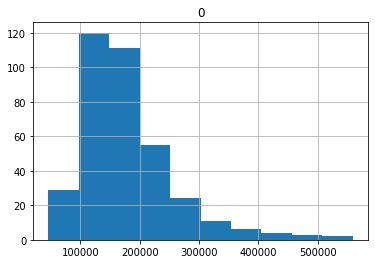

In [464]:
pd.DataFrame(clf.predict(xtest)).hist()



In [517]:
ytest

,SalePrice
734,108000
1367,127000
151,372402
1270,260000
834,139950
497,184000
744,180000
1219,91500
152,190000
689,194700


In [519]:
result = pd.DataFrame({'diff': np.ravel(ytest) - clf.predict(xtest), target: np.ravel(ytest)})

,diff,SalePrice
0,-21587.250000,108000
1,-2439.117188,127000
2,31480.593750,372402
3,51766.046875,260000
4,9460.335938,139950
5,13353.015625,184000
6,-53749.687500,180000
7,-17624.140625,91500
8,-13672.500000,190000
9,10992.843750,194700


# Submission

In [545]:
filename = 'submission.csv'
test = pd.read_csv(root + '/test.csv')
y_sub_test = test[target]
x_sub_test = test.drop([])
clf.predict(xtest)
pd.DataFrame({'Id': test.Id, 'SalePrice': test.Prediction}).to_csv(root + '/' + filename, index=False)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,Comp